## I. Regression Modeling

In [43]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns

from astsadata import *


In [44]:
def ccf(x, y, max_lag, ccf_type='correlation', ax=None, return_values=False, **kwargs):
    """
    Calculate and optionally plot the cross-correlation or cross-covariance function.

    Parameters:
    - x, y: Input time series.
    - max_lag: Maximum lag to compute.
    - ccf_type: 'correlation' for cross-correlation, 'covariance' for cross-covariance.
    - ax: Matplotlib axis to plot on. If None, a new axis is created.
    - return_values: If True, the function will return the CCF/CCoV values and lags.
    - **kwargs: Additional keyword arguments for the plot.

    Returns:
    - If return_values is True, returns (lags, ccf).
    """
    #import statsmodels.api as sm

    lags = np.arange(-max_lag, max_lag + 1)

    if ccf_type == 'correlation':
        backwards = sm.tsa.ccf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
        forwards = sm.tsa.ccf(x, y, adjusted=False)[:max_lag + 1]
        ccf = np.r_[backwards[:-1], forwards]
        ylabel = 'CCF'
    elif ccf_type == 'covariance':
        backwards = sm.tsa.ccovf(x[::-1], y[::-1], adjusted=False)[max_lag::-1]
        forwards = sm.tsa.ccovf(x, y, adjusted=False)[:max_lag + 1]
        ccf = np.r_[backwards[:-1], forwards]
        ylabel = 'CCoV'

    if return_values:
        return lags, ccf

    if ax is None:
        ax = plt.gca()

    ax.bar(lags, ccf, **kwargs)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    if ccf_type == 'correlation':
        conf_level = 1.96 / np.sqrt(x.shape[0])
        ax.axhline(conf_level, color='red', linestyle='--', linewidth=1)
        ax.axhline(-conf_level, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel('LAG')
    ax.set_ylabel(ylabel)

    return ax


In [45]:
# Read the dataset

df = pd.read_csv(r'C:\zshahpouri\Forecasting_Predictive_Analytics\data\products_demand_data_series.csv', index_col = 0, parse_dates = True)
start_date = "2019-07-08"
df.index = pd.date_range(start=start_date, periods=len(df), freq="D")

df.index = pd.to_datetime(df.index, format="%Y-%m-%d")  # Adjust format as needed
rename_dict = {
    "ProductP1": "p1",
    "ProductP2": "p2",
    "ProductP3": "p3",
    "ProductP4": "p4",
    "ProductP5": "p5",
    "temperature": "temp"
}

df.rename(columns=rename_dict, inplace=True)
df.drop(['price', 'p5'], axis=1, inplace=True)
df = df.astype(float)



In [46]:
X = np.log(df[:-14])

# Test set
X_test = np.log(df[-14:])

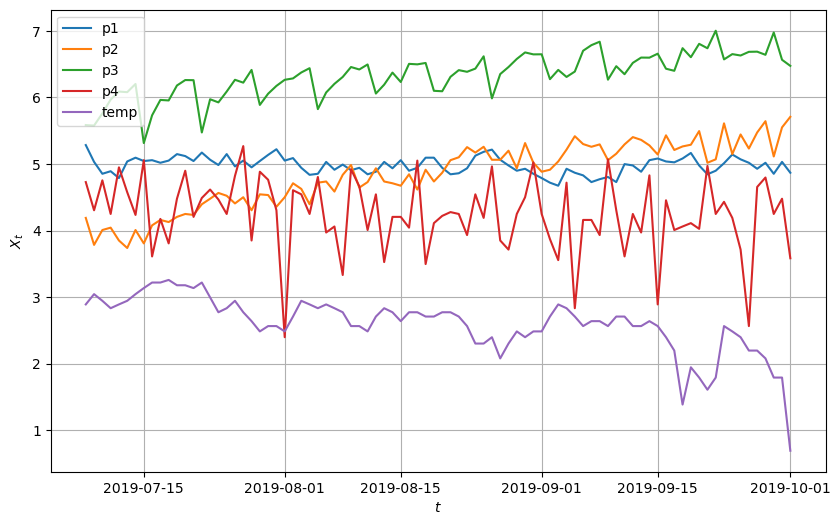

In [47]:
plt.figure(figsize=(10, 6)) 
plt.plot(X) 
plt.xlabel('$t$') 
plt.ylabel('$X_t$') 
plt.grid(True) 
plt.legend(X.columns, loc = 'upper left') 
plt.show()  

In [48]:
p1_ts = pd.Series(X.values[:,0], index = X.index)
p2_ts = pd.Series(X.values[:,1], index = X.index)
p3_ts = pd.Series(X.values[:,2], index = X.index)
p4_ts = pd.Series(X.values[:,3], index = X.index)
temp_ts = pd.Series(X.values[:,3], index = X.index)

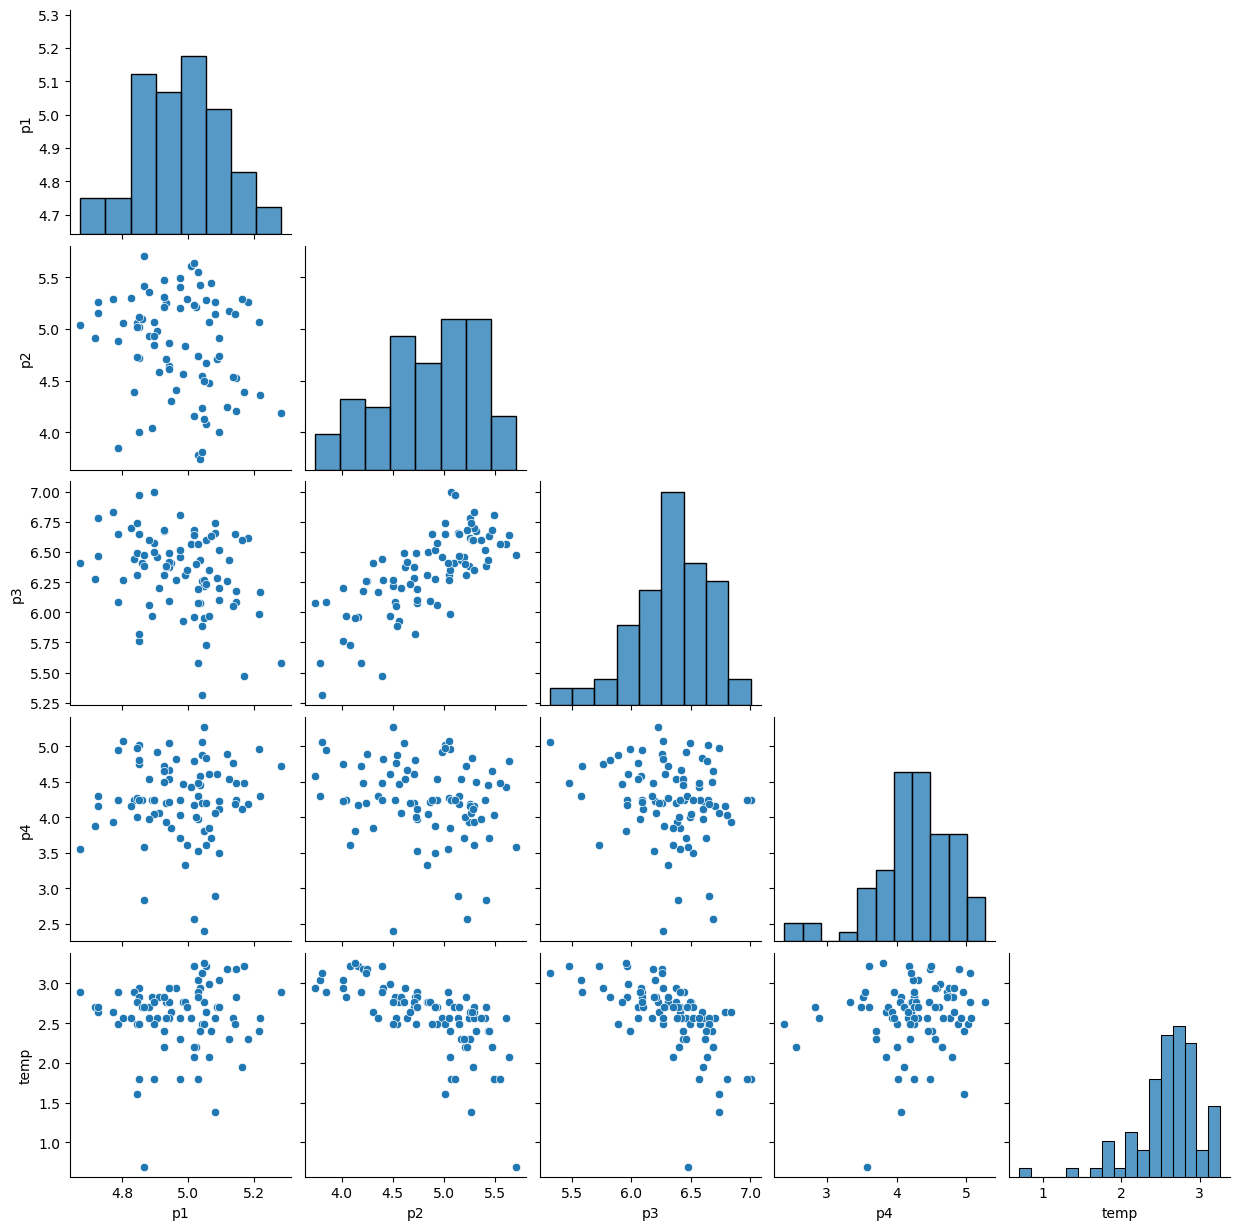

In [49]:
# Mask to remove duplicates
g = sns.pairplot(X)
# Hide the upper triangle
for i, j in zip(*np.triu_indices_from(g.axes, k=1)):  # k=1 keeps the diagonal
    g.axes[i, j].set_visible(False)  # Hide upper triangle plots

plt.show()

-----

### First Model
For the first model, according to the plots we assume there is a good correlation between fiets and strand.

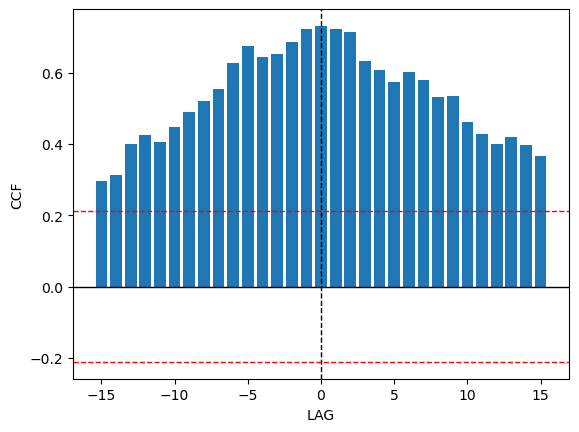

In [50]:
ccf(p3_ts, p2_ts, max_lag = 15)
plt.show()

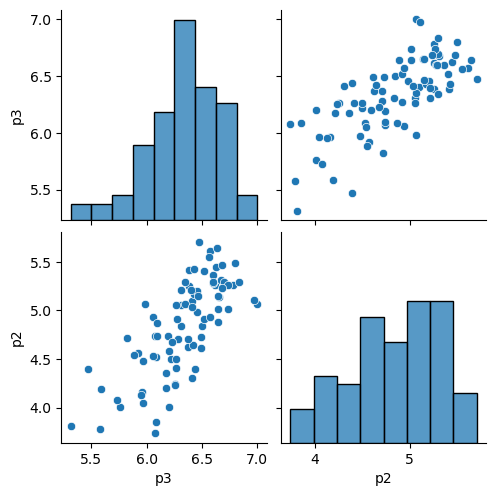

In [51]:
# p2_2_ts = p2_ts.shift(2)
X2= pd.DataFrame({'p3': p3_ts, 'p2': p2_ts}).dropna()

sns.pairplot(X2)

plt.show()

In [52]:
# Regression modeling

model_1= ols(formula = 'p3 ~ p2', data = X2).fit()

print(model_1.summary())


                            OLS Regression Results                            
Dep. Variable:                     p3   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     96.43
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           1.33e-15
Time:                        20:44:53   Log-Likelihood:                 6.6343
No. Observations:                  86   AIC:                            -9.269
Df Residuals:                      84   BIC:                            -4.360
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9238      0.246     15.945      0.0

-----

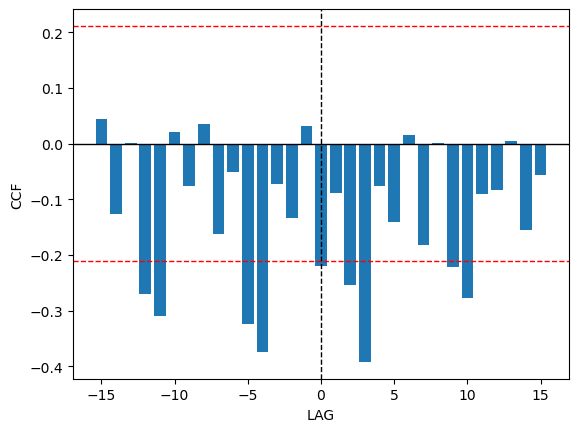

In [53]:
# Cross-correlation between fiets and handschoenen

ccf(p3_ts, temp_ts, max_lag = 15)
plt.show()


By shifting handschoenen to 6 lag later, we can get a better results.

In [54]:
temp_2_ts = temp_ts.shift(3)
X3= pd.DataFrame({'p3': p3_ts, 'p2': p2_ts, 'temp_3': temp_2_ts}).dropna()
model_3 = ols(formula = 'p3 ~ p2 + temp_3', data = X3).fit()

print(model_3.summary())


                            OLS Regression Results                            
Dep. Variable:                     p3   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     54.26
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           1.29e-15
Time:                        20:44:53   Log-Likelihood:                 16.085
No. Observations:                  83   AIC:                            -26.17
Df Residuals:                      80   BIC:                            -18.91
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0455      0.323     15.614      0.0

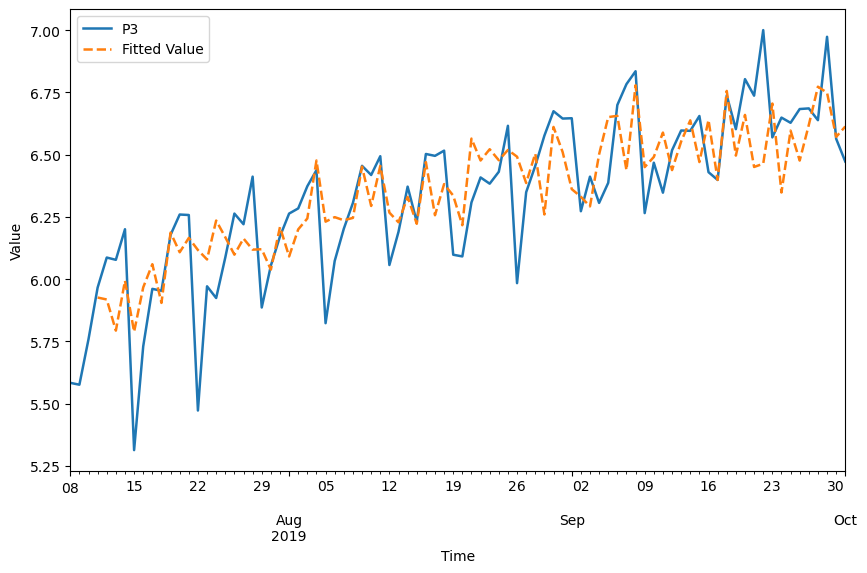

In [55]:
# Plot the time series data and the fitted values on the training set

p3_ts_predict = pd.Series(model_3.fittedvalues.values, index=X.index[3:])

plt.figure(figsize = (10, 6))

p3_ts.plot(linewidth = 1.8)
p3_ts_predict.plot(linestyle = '--', linewidth = 1.8)

plt.title('')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['P3', 'Fitted Value'], loc = 'upper left') 

plt.show()


## III. Hybrid SARIMA-Regression Models

In [60]:
data = df['p3']
# Training set
train_data = np.log(data[:-14])

# Test set
test_data = np.log(data[-14:])


# Prepare exogenous variables
exog_train = X.loc[X.index, ['p2', 'temp']]
exog_test = X_test.loc[X_test.index, ['p2', 'temp']]

# Verify the shapes
print(f"Exogenous Train Shape: {exog_train.shape}")
print(f"Exogenous Test Shape: {exog_test.shape}")

Exogenous Train Shape: (86, 2)
Exogenous Test Shape: (14, 2)


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Fit the SARIMAX model with exogenous variables
model_exog = SARIMAX(train_data, order=(0, 1, 1), seasonal_order=(0, 1, 1, 7), exog=exog_train)
results_exog = model_exog.fit()

# Display model summary
print(results_exog.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                p3   No. Observations:                   86
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                  56.476
Date:                           Fri, 07 Feb 2025   AIC                           -102.952
Time:                                   20:51:07   BIC                            -91.168
Sample:                               07-08-2019   HQIC                           -98.235
                                    - 10-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p2            -0.0219      0.059     -0.371      0.711      -0.138       0.094
temp          -0.0546      0.032     -1.704